# Creation of our own model

In [1]:
from carRecognition import display_bounding_boxes

import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F
import matplotlib.pylab as plt
import numpy as np

import os
import json
import torch
from torch.utils.data import Dataset, DataLoader, random_split
# from PIL import Image
import torchvision.transforms as transforms
import pandas as pd

import cv2
torch.manual_seed(2)

# https://www.kaggle.com/datasets/sshikamaru/car-object-detection/data

In [2]:
# Global variables

NEW_WIDTH = 338
NEW_HEIGHT = 190

# NEW_HEIGHT = 190
# NEW_WIDTH = 338

# cv2     : [height, width, c]
# pytorch : [channels, height, width]

In [3]:
class CarRecognitionDataset(Dataset):
    def __init__(self, images_dir, csv_annotations, transform=None):
        self.images_dir = images_dir
        self.annotations = pd.read_csv(csv_annotations)
        self.transform = transform

    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.images_dir, self.annotations.iloc[index, 0])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # for display
        image = image[:,:,:3] # removing alpha cannal if it exists
        # must be (c, height, width)
        # note : trasnform.ToTensor() does the permute() alone
        y = torch.tensor(self.annotations.iloc[index, 1:5]) # 1:5 for bounding box coord
        y = y/2 # change to ratio

        image = self.transform(image) # transform has to resize


        return image, y

In [4]:
dataset = CarRecognitionDataset(csv_annotations='data/train_boxes.csv', images_dir='data/train/',
                                 transform = transforms.Compose([
                                     transforms.ToTensor(),
                                     transforms.Resize((NEW_HEIGHT, NEW_WIDTH))
                                 ]))

In [5]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, drop_last=True)

In [6]:
def train(model, criterion, train_loader, test_loader, optimizer, epochs=10):
    i = 0
    output = {'training_loss': [], 'test_accuracy': []}  
    
    for epoch in range(epochs):
        print(str(epoch) + " / " + str(epochs))
        for i, (image, box) in enumerate(train_loader):
            image=image.float()
            box=box.float()
            optimizer.zero_grad()
            z = model(image)
            loss = criterion(z, box)
            loss.backward()
            optimizer.step()
            output['training_loss'].append(loss.data.item())
        
        # correct = 0
        # for x, y in test_loader:
        #     z = model(x.view(-1, 128 * 128 * 3))
        #     _, label = torch.max(z, 1)
        #     print(z)
        #     correct += (label == y).sum().item()
    
        # accuracy = 100 * (correct / len(test_loader))
        # output['test_accuracy'].append(accuracy)
    
    return output

In [7]:
# https://www.youtube.com/watch?v=pDdP0TFzsoQ&ab_channel=PatrickLoeber

class CarRecognitionNet(nn.Module):
    def __init__(self, in_size):
        super(CarRecognitionNet, self).__init__()
        # 338, 190
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=1)
        # 336, 188
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # 168, 94
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=1)
        # 166, 92

        self.dynamic_input = int(((((NEW_HEIGHT-2)//2)-2)//2) * ((((NEW_WIDTH-2)//2)-2)//2) * 32)
        # pseudo-dynamic output of the conv layers

        self.fc1 = nn.Linear(self.dynamic_input, 128)
        self.fc2 = nn.Linear(128, 4) # 4 for the coordinates (x_min, y_min, x_max, y_max)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        x = x.view(-1, self.dynamic_input) # -1 should be batch_size
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # coordinates prediction
        return x
    

In [8]:
import torch.optim as optim

# images INITIAL shape : 676 x 380

learning_rate = 0.0005
epochs = 1000
model = CarRecognitionNet(NEW_WIDTH*NEW_HEIGHT*3) # image size et 3 canaux RGB

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

output=train(model, criterion, train_loader, val_loader, optimizer, epochs)




0 / 500
1 / 500
2 / 500
3 / 500
4 / 500
5 / 500
6 / 500
7 / 500
8 / 500
9 / 500
10 / 500
11 / 500
12 / 500
13 / 500
14 / 500
15 / 500
16 / 500
17 / 500
18 / 500
19 / 500
20 / 500
21 / 500
22 / 500
23 / 500
24 / 500
25 / 500
26 / 500
27 / 500
28 / 500
29 / 500
30 / 500
31 / 500
32 / 500
33 / 500
34 / 500
35 / 500
36 / 500
37 / 500
38 / 500
39 / 500
40 / 500
41 / 500
42 / 500
43 / 500
44 / 500
45 / 500
46 / 500
47 / 500
48 / 500
49 / 500
50 / 500
51 / 500
52 / 500
53 / 500
54 / 500
55 / 500
56 / 500
57 / 500
58 / 500
59 / 500
60 / 500
61 / 500
62 / 500
63 / 500
64 / 500
65 / 500
66 / 500
67 / 500
68 / 500
69 / 500
70 / 500
71 / 500
72 / 500
73 / 500
74 / 500
75 / 500
76 / 500
77 / 500
78 / 500
79 / 500
80 / 500
81 / 500
82 / 500
83 / 500
84 / 500
85 / 500
86 / 500
87 / 500
88 / 500
89 / 500
90 / 500
91 / 500
92 / 500
93 / 500
94 / 500
95 / 500
96 / 500
97 / 500
98 / 500
99 / 500
100 / 500
101 / 500
102 / 500
103 / 500
104 / 500
105 / 500
106 / 500
107 / 500
108 / 500
109 / 500
110 / 500


done
tensor([[ 97.0740,  86.6099, 151.0358, 107.9927]])


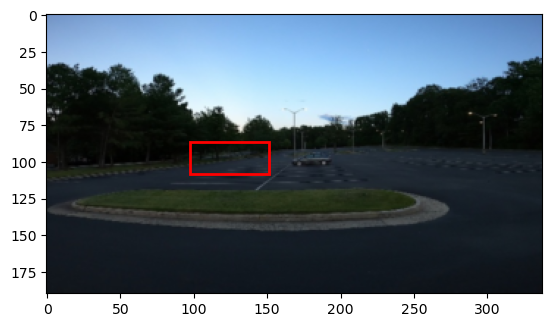

In [9]:
model.eval()
for name, param in model.named_parameters():
    param.requires_grad = False
print("done")

image_path = 'data/test/vid_5_400.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # for display
image = image[:,:,:3]

transform = transforms.Compose([transforms.ToTensor(), # -> [C, H, W]
                                transforms.Resize((NEW_HEIGHT, NEW_WIDTH))])
img = transform(image)

pred = model(img)
print(pred)
display_bounding_boxes(img.permute(1,2,0).numpy(), pred) # -> [H, W, C]

tensor([[ 94.3631,  85.2867, 138.3021, 106.9602]])


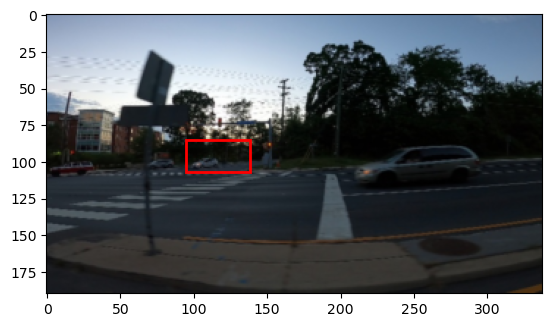

In [10]:
image_path = 'data/test/vid_5_27480.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # for display
image = image[:,:,:3]

transform = transforms.Compose([transforms.ToTensor(), # -> [C, H, W]
                                transforms.Resize((NEW_HEIGHT, NEW_WIDTH))])
img = transform(image)

pred = model(img)
print(pred)
display_bounding_boxes(img.permute(1,2,0).numpy(), pred) # -> [H, W, C]

tensor([[137.8241,  88.4568, 198.5226, 109.4721]])


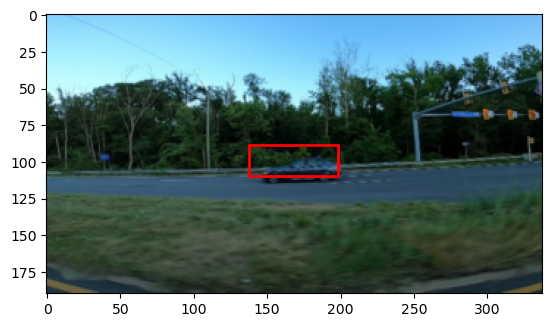

In [11]:
image_path = 'data/train/vid_4_600.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # for display
image = image[:,:,:3]

transform = transforms.Compose([transforms.ToTensor(), # -> [C, H, W]
                                transforms.Resize((NEW_HEIGHT, NEW_WIDTH))])
img = transform(image)

pred = model(img)
print(pred)
display_bounding_boxes(img.permute(1,2,0).numpy(), pred) # -> [H, W, C]

tensor([[ 81.8164,  86.9906, 180.8609, 126.1155]])


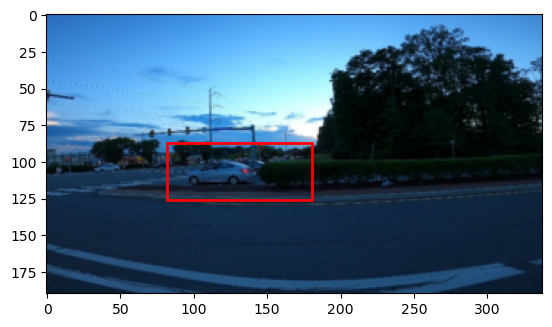

In [19]:
image_path = 'data/train/vid_4_30440.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # for display
image = image[:,:,:3]

transform = transforms.Compose([transforms.ToTensor(), # -> [C, H, W]
                                transforms.Resize((NEW_HEIGHT, NEW_WIDTH))])
img = transform(image)

pred = model(img)
print(pred)
display_bounding_boxes(img.permute(1,2,0).numpy(), pred) # -> [H, W, C]